In [126]:
# !pip install scikit-learn
# !pip install matplotlib
# !pip install numpy
# !pip install scikit-image
# !pip install torch

### 0. Задача обучения с учителем. Регрессия, Классификация

In [32]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.datasets import make_regression, make_classification

# --- Регрессия ---
X_reg, y_reg = make_regression(n_samples=100, n_features=2, noise=0.1, random_state=43) # [100, 2], [100]
reg = LinearRegression().fit(X_reg, y_reg)

# --- Классификация ---
X_clf, y_clf = make_classification(n_samples=100, n_features=2, n_classes=2, n_redundant=0, random_state=43) # [100, 2], [100]
clf = LogisticRegression().fit(X_clf, y_clf)


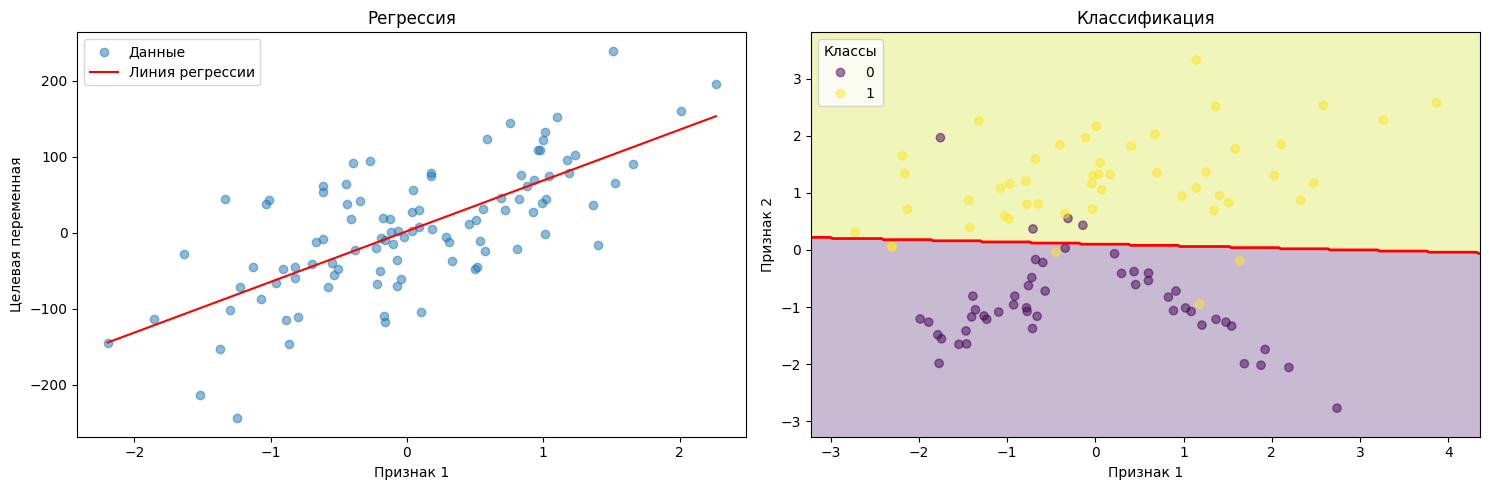

In [43]:


# --- Отрисовка ---
import matplotlib.pyplot as plt
import numpy as np

# Создаем фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# --- Регрессия ---
# Создаем сетку точек для линии регрессии
x_grid = np.linspace(X_reg[:, 0].min(), X_reg[:, 0].max(), 100).reshape(-1, 1)
# Добавляем второй признак (среднее значение) # отрисовать только 1 признак можем => по второму усредним! 
# так делать очень плохо! но для игрушечного примера - ок!
x_grid_full = np.column_stack([x_grid, np.full_like(x_grid, X_reg[:, 1].mean())])
y_pred = reg.predict(x_grid_full)

# Визуализация регрессии
ax1.scatter(X_reg[:, 0], y_reg, alpha=0.5, label='Данные')
ax1.plot(x_grid, y_pred, 'r-', label='Линия регрессии')
ax1.set_title('Регрессия')
ax1.set_xlabel('Признак 1')
ax1.set_ylabel('Целевая переменная')
ax1.legend()

# --- Классификация ---
# Создаем сетку точек для границы принятия решений
x_min, x_max = X_clf[:, 0].min() - 0.5, X_clf[:, 0].max() + 0.5
y_min, y_max = X_clf[:, 1].min() - 0.5, X_clf[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Предсказываем классы для всех точек сетки
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Визуализация классификации
ax2.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
ax2.contour(xx, yy, Z, [0.5], colors='red', linewidths=2)

scatter = ax2.scatter(X_clf[:, 0], X_clf[:, 1], c=y_clf, cmap='viridis', alpha=0.5)
ax2.set_title('Классификация')
ax2.set_xlabel('Признак 1')
ax2.set_ylabel('Признак 2')
ax2.legend(*scatter.legend_elements(), title="Классы")

plt.tight_layout()
plt.show()

In [42]:
xx.shape, yy.shape, np.arange(x_min, x_max, 0.02).shape

((355, 380), (355, 380), (380,))

### 1. Метрики классификации: accuracy, balanced accuracy, precision, recall, f1-score, ROC-AUC, расширения для многоклассовой классификации

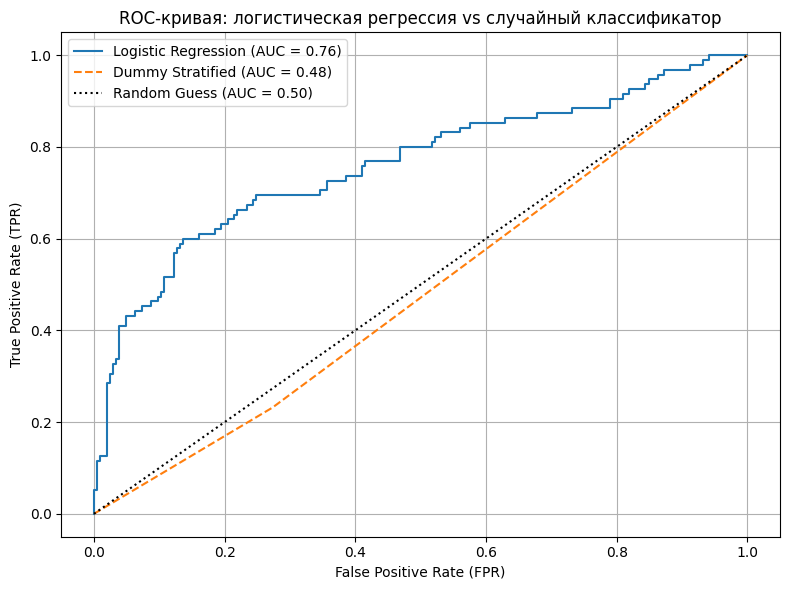

In [54]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# --- 1. Синтетические, "грязные" данные ---
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=5,
    n_redundant=4,
    n_classes=2,
    weights=[0.75, 0.25],  # дисбаланс классов
    flip_y=0.1,            # 10% меток шумные
    class_sep=0.8,         # классы частично пересекаются
    random_state=42
)

# --- 2. Деление на train/test ---
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=42)

# --- 3. Логистическая регрессия ---
model = LogisticRegression(max_iter=1000).fit(X_tr, y_tr)
y_prob = model.predict_proba(X_te)[:, 1]
fpr_model, tpr_model, _ = roc_curve(y_te, y_prob)
auc_model = roc_auc_score(y_te, y_prob)

# --- 4. Dummy-классификатор (стратегия stratified) ---
dummy = DummyClassifier(strategy='stratified', random_state=42).fit(X_tr, y_tr)
y_dummy_prob = dummy.predict_proba(X_te)[:, 1]
fpr_dummy, tpr_dummy, _ = roc_curve(y_te, y_dummy_prob)
auc_dummy = roc_auc_score(y_te, y_dummy_prob)

# --- 5. Визуализация ROC-кривых ---
plt.figure(figsize=(8, 6))
plt.plot(fpr_model, tpr_model, label=f"Logistic Regression (AUC = {auc_model:.2f})")
plt.plot(fpr_dummy, tpr_dummy, linestyle='--', label=f"Dummy Stratified (AUC = {auc_dummy:.2f})")
plt.plot([0, 1], [0, 1], 'k:', label="Random Guess (AUC = 0.50)")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC-кривая: логистическая регрессия vs случайный классификатор")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### 2. Метрики регрессии: MSE, MAE, R²


In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.model_selection import train_test_split

# Данные
X, y = make_regression(n_samples=500, noise=15, random_state=42)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=42)

# --- Линейная регрессия ---
model_lr = LinearRegression().fit(X_tr, y_tr)
y_pred_lr = model_lr.predict(X_te)

print("=== Linear Regression ===")
print("MSE:", mean_squared_error(y_te, y_pred_lr))
print("MAE:", mean_absolute_error(y_te, y_pred_lr))
print("R²:", r2_score(y_te, y_pred_lr))

# --- Huber-регрессия ---
model_huber = HuberRegressor().fit(X_tr, y_tr)
y_pred_huber = model_huber.predict(X_te)

print("\n=== Huber Regressor ===")
print("MSE:", mean_squared_error(y_te, y_pred_huber))
print("MAE:", mean_absolute_error(y_te, y_pred_huber))
print("R²:", r2_score(y_te, y_pred_huber))

=== Linear Regression ===
MSE: 334.45719591398216
MAE: 14.30958669001259
R²: 0.988668164971938

=== Huber Regressor ===
MSE: 367.2515287731075
MAE: 15.169297076822216
R²: 0.9875570512797974


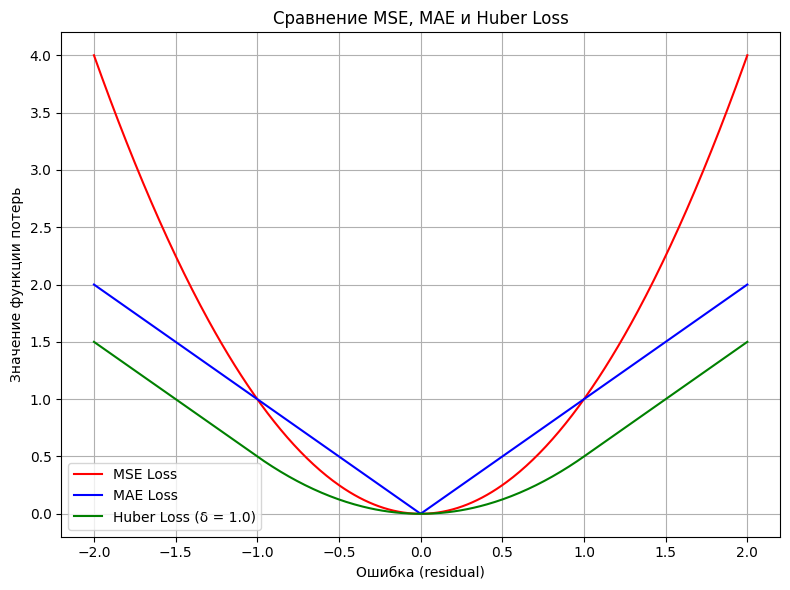

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Ошибки (residuals)
errors = np.linspace(-2, 2, 400)

# MSE: квадратичные потери
mse_loss = errors ** 2

# MAE: абсолютные потери
mae_loss = np.abs(errors)

# Huber loss
delta = 1.0
huber_loss = np.where(
    np.abs(errors) <= delta,
    0.5 * errors ** 2,
    delta * (np.abs(errors) - 0.5 * delta)
)

# Визуализация
plt.figure(figsize=(8, 6))
plt.plot(errors, mse_loss, label='MSE Loss', color='red')
plt.plot(errors, mae_loss, label='MAE Loss', color='blue')
plt.plot(errors, huber_loss, label='Huber Loss (δ = 1.0)', color='green')
plt.xlabel("Ошибка (residual)")
plt.ylabel("Значение функции потерь")
plt.title("Сравнение MSE, MAE и Huber Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 3. Оценка максимального правдоподобия (MLE), связь с регрессией и классификацией

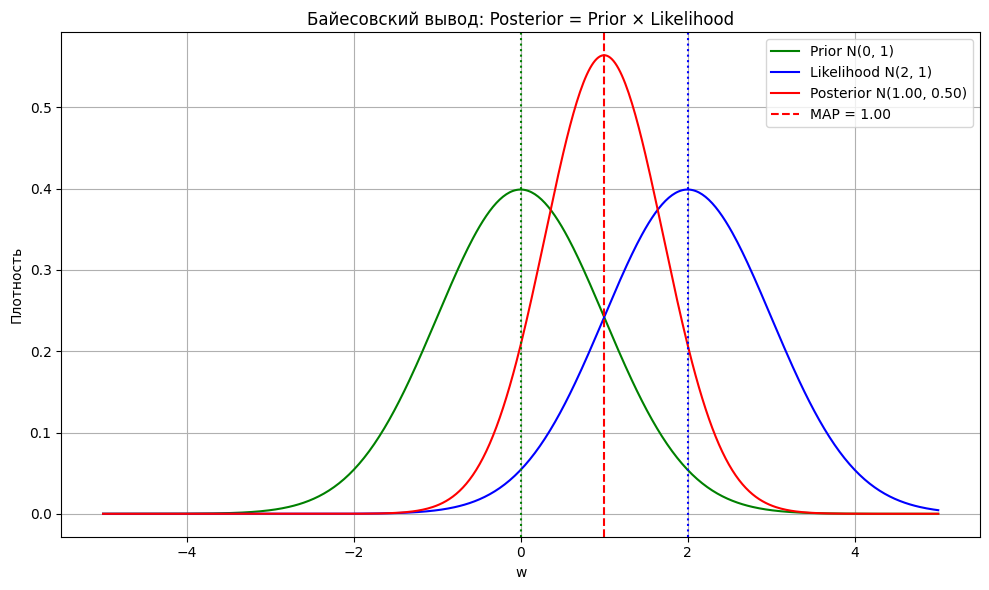

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Ось параметра w
w = np.linspace(-5, 5, 500)

# Заданные параметры
mu0, sigma0 = 0, 1     # prior: N(0, 1)
mu1, sigma1 = 2, 1     # likelihood: N(2, 1)

# Распределения
prior = norm.pdf(w, loc=mu0, scale=sigma0)
likelihood = norm.pdf(w, loc=mu1, scale=sigma1)

# Постериорное распределение — аналитически
sigma_post_sq = 1 / (1/sigma0**2 + 1/sigma1**2)
mu_post = sigma_post_sq * (mu0/sigma0**2 + mu1/sigma1**2)
posterior = norm.pdf(w, loc=mu_post, scale=np.sqrt(sigma_post_sq))

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(w, prior, label=f"Prior N({mu0}, {sigma0**2})", color='green')
plt.plot(w, likelihood, label=f"Likelihood N({mu1}, {sigma1**2})", color='blue')
plt.plot(w, posterior, label=f"Posterior N({mu_post:.2f}, {sigma_post_sq:.2f})", color='red')

plt.axvline(mu0, color='green', linestyle=':')
plt.axvline(mu1, color='blue', linestyle=':')
plt.axvline(mu_post, color='red', linestyle='--', label=f"MAP = {mu_post:.2f}")

plt.title("Байесовский вывод: Posterior = Prior × Likelihood")
plt.xlabel("w")
plt.ylabel("Плотность")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 4. Наивный байесовский классификатор


In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from scipy.special import logsumexp

# --- 1. Загрузка и подготовка данных
iris = load_iris()
X = iris.data[:, [2, 3]]  # два признака: длина и ширина лепестка
y = iris.target
feature_names = np.array(iris.feature_names)[[2, 3]]
class_names = iris.target_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [60]:
# --- 2. Обёртка KDE
class KDEWrapper:
    def __init__(self, data):
        self.kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(data[:, None])

    def logpdf(self, x):
        return self.kde.score_samples(x[:, None])
    

#  --- 3. NaiveBayes из тетрадки
class NaiveBayes:
    def fit(self, X, y, sample_weight=None, distributions=None):
        self.unique_labels = np.unique(y)
        if distributions is None:
            distributions = [KDEWrapper] * X.shape[1]
        assert len(distributions) == X.shape[1]
        self.conditional_feature_distributions = {}
        for label in self.unique_labels:
            dists = []
            for i in range(X.shape[1]):
                dists.append(distributions[i](X[y == label, i]))
            self.conditional_feature_distributions[label] = dists
        self.prior_label_distibution = {l: np.mean(y == l) for l in self.unique_labels}

    def predict_log_proba(self, X):
        log_proba = np.zeros((X.shape[0], len(self.unique_labels)))
        for i, label in enumerate(self.unique_labels):
            for j in range(X.shape[1]):
                log_proba[:, i] += self.conditional_feature_distributions[label][j].logpdf(X[:, j])
            log_proba[:, i] += np.log(self.prior_label_distibution[label])
        log_proba -= logsumexp(log_proba, axis=1)[:, None]
        return log_proba

    def predict(self, X):
        return self.unique_labels[np.argmax(self.predict_log_proba(X), axis=1)]

In [62]:
# --- 4. Обучение моделей
model_kde = NaiveBayes()
model_kde.fit(X_train, y_train, distributions=[KDEWrapper, KDEWrapper])
y_pred_kde = model_kde.predict(X_test)

model_gnb = GaussianNB()
model_gnb.fit(X_train, y_train)
y_pred_gnb = model_gnb.predict(X_test)

print("KDE NB Accuracy:", accuracy_score(y_test, y_pred_kde))
print("GaussianNB Accuracy:", accuracy_score(y_test, y_pred_gnb))

KDE NB Accuracy: 1.0
GaussianNB Accuracy: 1.0


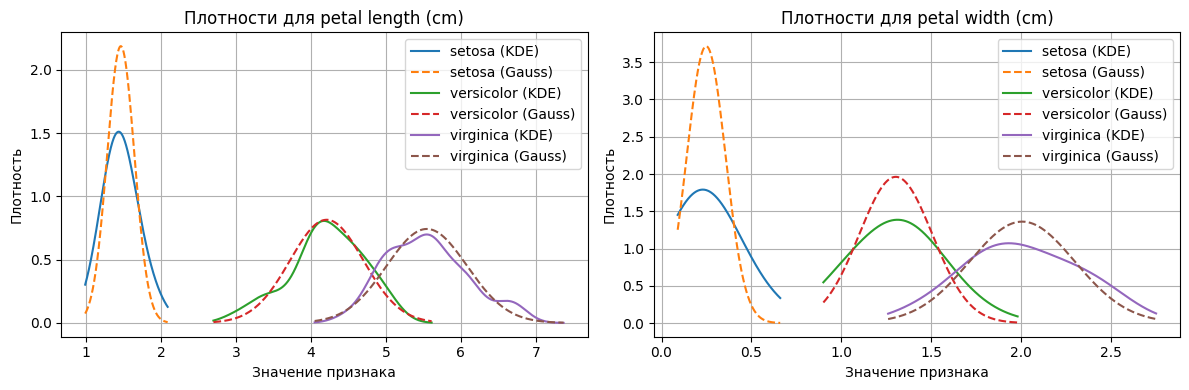

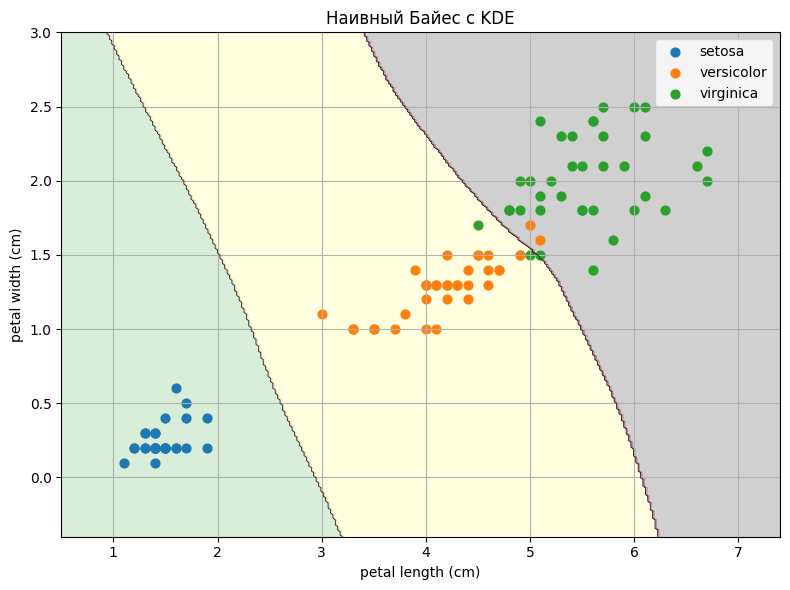

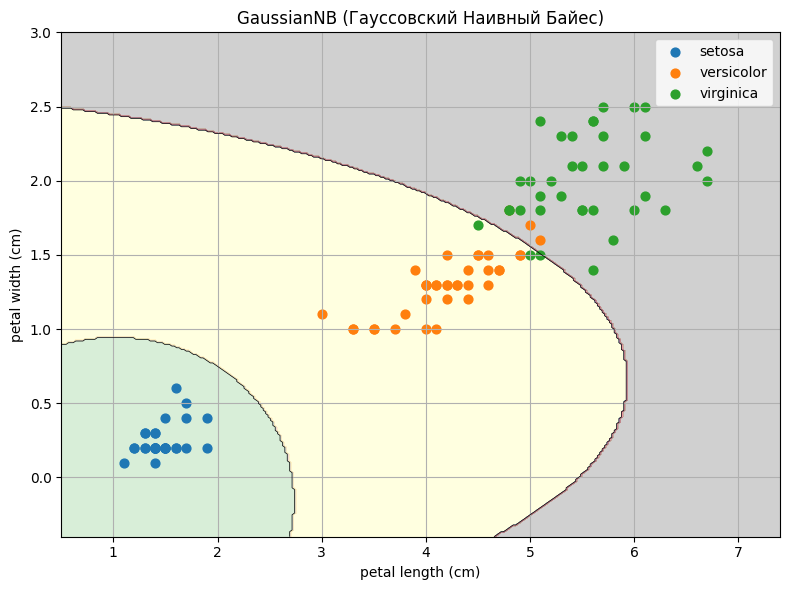

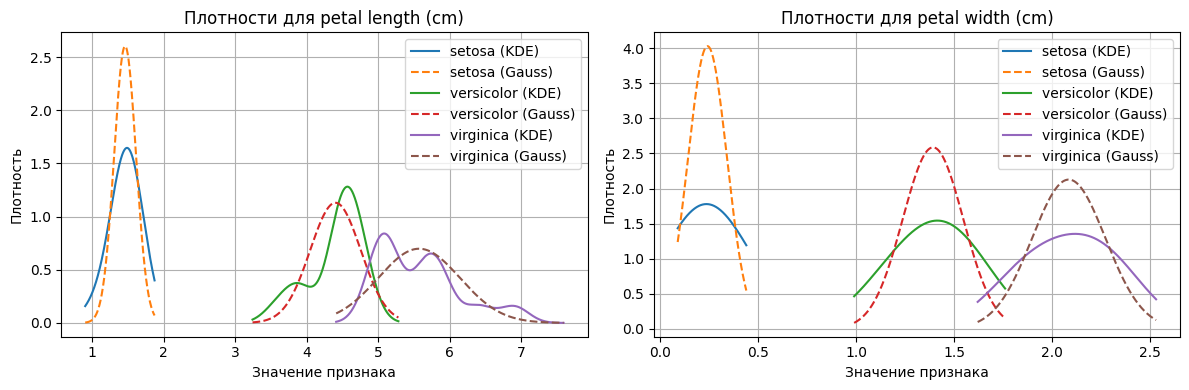

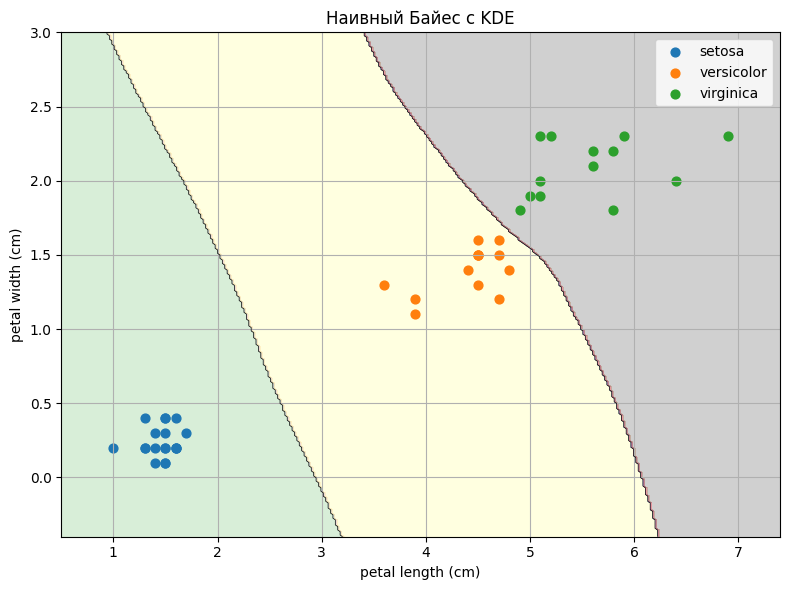

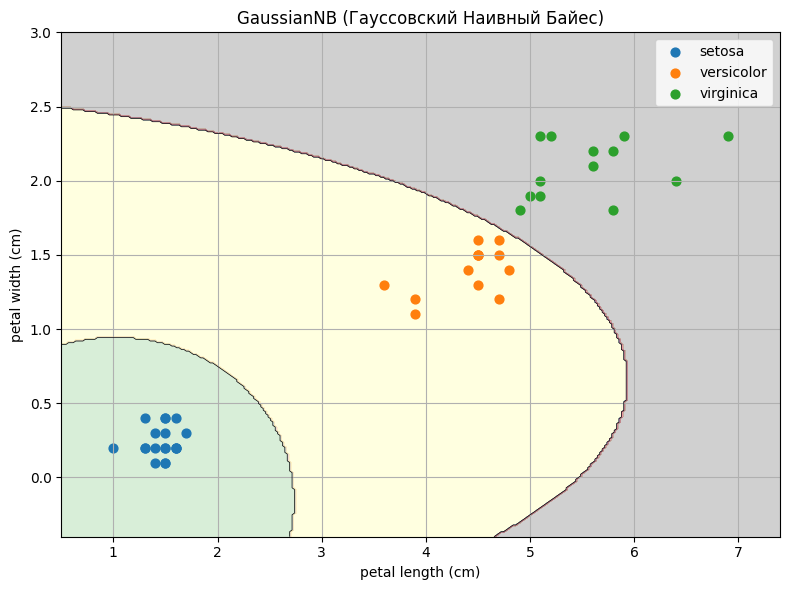

In [71]:
# --- 5. Визуализация KDE-плотностей
def plot_kde_and_gaussian_densities(X_data, y_data):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Обучим GaussianNB — он сам оценит параметры
    gnb = GaussianNB()
    gnb.fit(X_data, y_data)

    for i in range(X_data.shape[1]):
        ax = axes[i]
        for label in np.unique(y_data):
            x_vals = X_data[y_data == label, i]
            grid = np.linspace(x_vals.min() * 0.9, x_vals.max() * 1.1, 500)

            # --- KDE
            kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(x_vals[:, None])
            ax.plot(grid, np.exp(kde.score_samples(grid[:, None])), label=f'{class_names[label]} (KDE)', linestyle='-')

            # --- Gauss via GaussianNB
            mu = gnb.theta_[label, i]
            sigma = np.sqrt(gnb.var_[label, i])
            ax.plot(grid, norm.pdf(grid, mu, sigma), label=f'{class_names[label]} (Gauss)', linestyle='--')


        ax.set_title(f'Плотности для {feature_names[i]}')
        ax.set_xlabel('Значение признака')
        ax.set_ylabel('Плотность')
        ax.legend()
        ax.grid()

    plt.tight_layout()
    plt.show()

# --- 6. Визуализация границ решений
def plot_decision_boundary(X_data, y_data, model, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='Accent')
    plt.contour(xx, yy, Z, levels=np.arange(0, 4), colors='k', linewidths=0.5)
    for label in np.unique(y_train):
        plt.scatter(X_data[y_data == label, 0], X_data[y_data == label, 1],label=class_names[label], s=40)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# train
plot_kde_and_gaussian_densities(X_train, y_train)
plot_decision_boundary(X_train, y_train, model_kde, "Наивный Байес с KDE")
plot_decision_boundary(X_train, y_train, model_gnb, "GaussianNB (Гауссовский Наивный Байес)")
# test
plot_kde_and_gaussian_densities(X_test, y_test)
plot_decision_boundary(X_test, y_test, model_kde, "Наивный Байес с KDE")
plot_decision_boundary(X_test, y_test, model_gnb, "GaussianNB (Гауссовский Наивный Байес)")

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.datasets import load_iris
# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KernelDensity
# from sklearn.metrics import accuracy_score
# from sklearn.naive_bayes import GaussianNB
# from scipy.special import logsumexp

# # --- 1. Загрузка и подготовка данных
# iris = load_iris()
# X = iris.data[:, [2, 3]]  # два признака: длина и ширина лепестка
# y = iris.target
# feature_names = np.array(iris.feature_names)[[2, 3]]
# class_names = iris.target_names

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # --- 2. Обёртка KDE
# class KDEWrapper:
#     def __init__(self, data):
#         self.kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(data[:, None])

#     def logpdf(self, x):
#         return self.kde.score_samples(x[:, None])

# --- 3. NaiveBayes из тетрадки
class NaiveBayes:
    def fit(self, X, y, sample_weight=None, distributions=None):
        self.unique_labels = np.unique(y)
        if distributions is None:
            distributions = [KDEWrapper] * X.shape[1]
        assert len(distributions) == X.shape[1]
        self.conditional_feature_distributions = {}
        for label in self.unique_labels:
            dists = []
            for i in range(X.shape[1]):
                dists.append(distributions[i](X[y == label, i]))
            self.conditional_feature_distributions[label] = dists
        self.prior_label_distibution = {l: np.mean(y == l) for l in self.unique_labels}

    def predict_log_proba(self, X):
        log_proba = np.zeros((X.shape[0], len(self.unique_labels)))
        for i, label in enumerate(self.unique_labels):
            for j in range(X.shape[1]):
                log_proba[:, i] += self.conditional_feature_distributions[label][j].logpdf(X[:, j])
            log_proba[:, i] += np.log(self.prior_label_distibution[label])
        log_proba -= logsumexp(log_proba, axis=1)[:, None]
        return log_proba

    def predict(self, X):
        return self.unique_labels[np.argmax(self.predict_log_proba(X), axis=1)]

# --- 4. Обучение моделей
model_kde = NaiveBayes()
model_kde.fit(X_train, y_train, distributions=[KDEWrapper, KDEWrapper])
y_pred_kde = model_kde.predict(X_test)

model_gnb = GaussianNB()
model_gnb.fit(X_train, y_train)
y_pred_gnb = model_gnb.predict(X_test)

print("KDE NB Accuracy:", accuracy_score(y_test, y_pred_kde))
print("GaussianNB Accuracy:", accuracy_score(y_test, y_pred_gnb))

# --- 5. Визуализация KDE-плотностей
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i in range(X.shape[1]):
    ax = axes[i]
    for label in np.unique(y):
        x_vals = X_train[y_train == label, i]
        kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(x_vals[:, None])
        grid = np.linspace(x_vals.min() * 0.9, x_vals.max() * 1.1, 500)
        ax.plot(grid, np.exp(kde.score_samples(grid[:, None])), label=class_names[label])
    ax.set_title(f'KDE для {feature_names[i]}')
    ax.set_xlabel('Значение признака')
    ax.set_ylabel('Плотность')
    ax.legend()
    ax.grid()
plt.tight_layout()
plt.show()

# --- 6. Визуализация границ решений
def plot_decision_boundary(model, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='Accent')
    plt.contour(xx, yy, Z, levels=np.arange(0, 4), colors='k', linewidths=0.5)
    for label in np.unique(y_train):
        plt.scatter(X_train[y_train == label, 0], X_train[y_train == label, 1],
                    label=class_names[label], s=40)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Границы
plot_decision_boundary(model_kde, "Наивный Байес с KDE")
plot_decision_boundary(model_gnb, "GaussianNB (Гауссовский Наивный Байес)")


### 5. Метод ближайших соседей


In [80]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import mode

# --- 1. Загружаем данные
digits = load_digits()
X = digits.data
y = digits.target

# Масштабирование
X = StandardScaler().fit_transform(X)

# Разделение
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=42)

# --- 2. Своя реализация k-NN (евклидовая метрика)
class MyKNN:
    def __init__(self, n_neighbors=5):
        self.k = n_neighbors

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = []
        for x in X:
            dists = np.linalg.norm(self.X_train - x, axis=1)
            nearest = np.argsort(dists)[:self.k]
            labels = self.y_train[nearest]
            pred = mode(labels, keepdims=False).mode 
            predictions.append(pred)
        return np.array(predictions)

# --- 3. Обучение и сравнение
# sklearn
sk_knn = KNeighborsClassifier(n_neighbors=5)
sk_knn.fit(X_tr, y_tr)
y_pred_sk = sk_knn.predict(X_te)
acc_sk = accuracy_score(y_te, y_pred_sk)

# наш
my_knn = MyKNN(n_neighbors=5)
my_knn.fit(X_tr, y_tr)
y_pred_my = my_knn.predict(X_te)
acc_my = accuracy_score(y_te, y_pred_my)

assert np.isclose(acc_sk, acc_my, rtol=1e-6), 'Точности не совпдают!'
print(f"{acc_sk=} {acc_my=}")
# acc_sk=0.9777777777777777 acc_my=0.9777777777777777

acc_sk=0.9777777777777777 acc_my=0.9777777777777777


### 6. Линейная регрессия. Формулировка задачи для случая функции потерь MSE. Аналитическое решение. Теорема Гаусса-Маркова. Градиентный подход в линейной регрессии.

MSE (аналитика): 230.84267462302407
MSE (градиент): 230.84267462302407


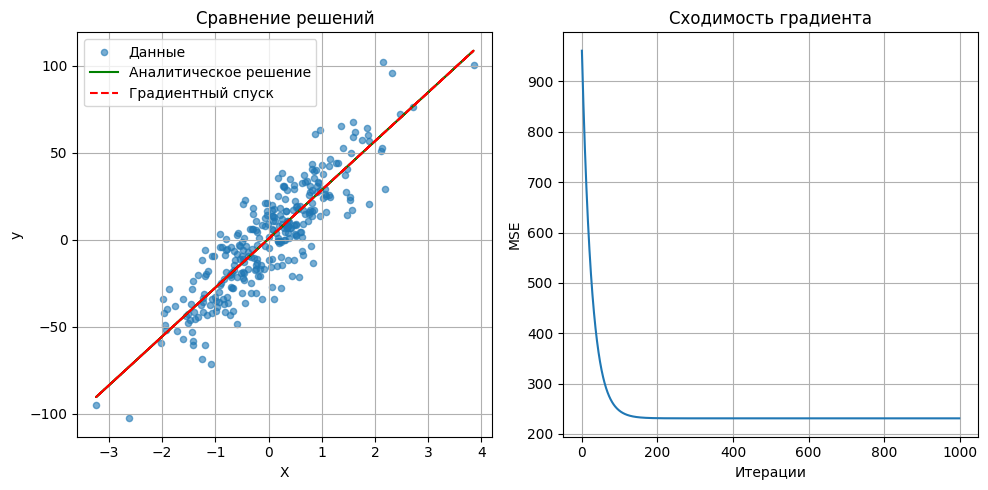

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

# --- Данные
X_raw, y = make_regression(n_samples=300, n_features=1, noise=15, random_state=42)
X = np.hstack([X_raw, np.ones((X_raw.shape[0], 1))])  # добавим bias

# --- Аналитическое решение
w_analytic = np.linalg.inv(X.T @ X) @ X.T @ y
y_pred_analytic = X @ w_analytic

# --- Градиентный спуск
w = np.zeros(X.shape[1])
lr = 0.01
losses = []

for _ in range(1000):
    grad = 2 * X.T @ (X @ w - y) / len(y)
    w -= lr * grad
    losses.append(mean_squared_error(y, X @ w))

y_pred_gd = X @ w

# --- Сравнение
print("MSE (аналитика):", mean_squared_error(y, y_pred_analytic))
print("MSE (градиент):", mean_squared_error(y, y_pred_gd))

# --- Визуализация
plt.figure(figsize=(10, 5))

# 1. Предсказания
plt.subplot(1, 2, 1)
plt.scatter(X_raw, y, s=20, alpha=0.6, label='Данные')
plt.plot(X_raw, y_pred_analytic, label='Аналитическое решение', color='green')
plt.plot(X_raw, y_pred_gd, label='Градиентный спуск', color='red', linestyle='--')
plt.title("Сравнение решений")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid()

# 2. Потери во времени
plt.subplot(1, 2, 2)
plt.plot(losses, label="MSE (градиент)")
plt.title("Сходимость градиента")
plt.xlabel("Итерации")
plt.ylabel("MSE")
plt.grid()
plt.tight_layout()
plt.show()
# MSE (аналитика): 230.84267462302407
# MSE (градиент): 230.84267462302407

### 7. Регуляризация в линейных моделях: $L_1$, $L_2$, их свойства и вероятностная интерпретация

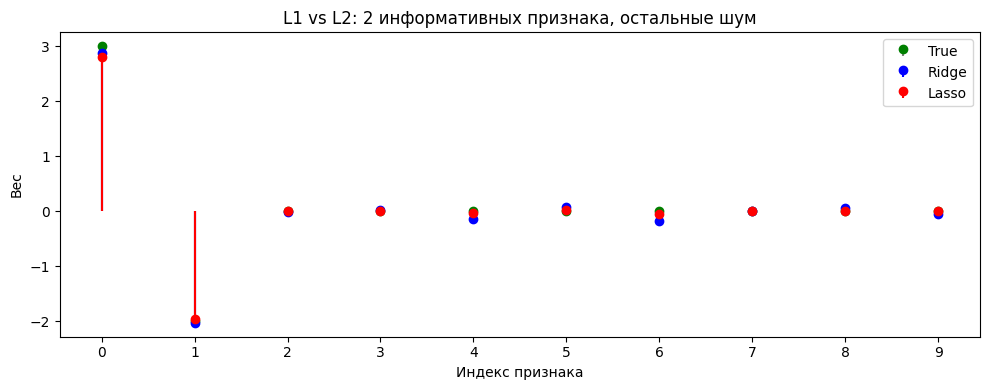

ridge_zeros=np.int64(0), flasso_zeros=np.int64(5)


In [ ]:
# Генерируем данные: 2 полезных признака + 8 шумовых

from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# --- Параметры
n_samples = 100
n_features = 10
n_informative = 2  # только два признака "полезные"

# --- Генерация данных
np.random.seed(42)
X = np.random.randn(n_samples, n_features)
true_coefs = np.zeros(n_features)
true_coefs[:n_informative] = [3, -2]  # только первые 2 признака значимы

# Целевая переменная с шумом
y = X @ true_coefs + np.random.normal(0, 1.0, size=n_samples)

# --- Обучение моделей
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.1)

ridge.fit(X, y)
lasso.fit(X, y)

# --- Сравнение весов
x_idx = np.arange(n_features)
plt.figure(figsize=(10, 4))
plt.stem(x_idx, true_coefs, linefmt="gray", markerfmt="go", basefmt=" ", label="True")
plt.stem(x_idx, ridge.coef_, linefmt="b-", markerfmt="bo", basefmt=" ", label="Ridge")
plt.stem(x_idx, lasso.coef_, linefmt="r-", markerfmt="ro", basefmt=" ", label="Lasso")
plt.xticks(ticks=x_idx)
plt.title("L1 vs L2: 2 информативных признака, остальные шум")
plt.xlabel("Индекс признака")
plt.ylabel("Вес")
plt.legend()
plt.tight_layout()
plt.show()

# --- Подсчёт зануленных весов
ridge_zeros = np.sum(np.abs(ridge.coef_) < 1e-4)
lasso_zeros = np.sum(np.abs(lasso.coef_) < 1e-4)
print(f"{ridge_zeros=}, f{lasso_zeros=}")
# ridge_zeros=np.int64(0), flasso_zeros=np.int64(5)

### 8. Логистическая регрессия. Эквивалентность MLE и логистических потерь

пока хз


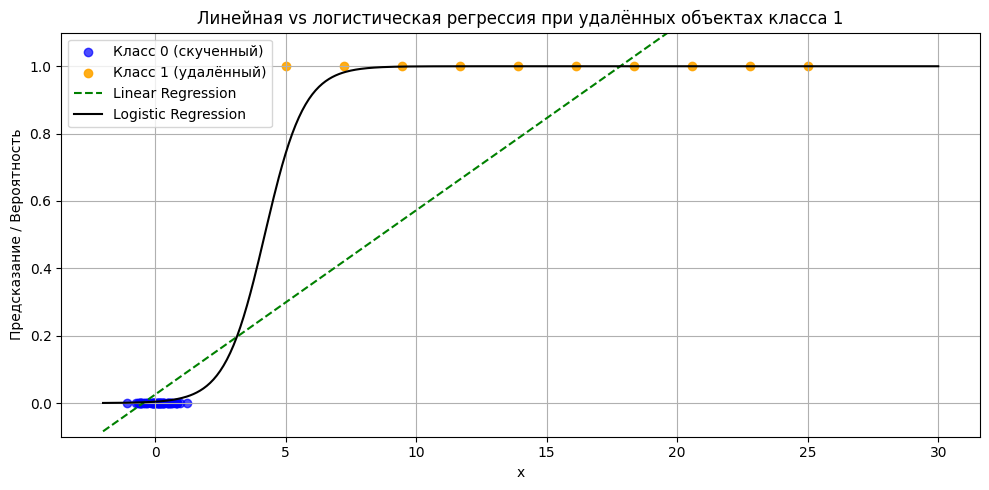

In [110]:
# Новый пример: класс 0 сконцентрирован в одном месте, класс 1 — сильно растянут вправо

# Класс 0 — 50 точек около x = 0
X0 = np.random.normal(loc=0, scale=0.5, size=(50, 1))
y0 = np.zeros(50)

# Класс 1 — 10 точек с растущим x (от 5 до 25)
X1 = np.linspace(5, 25, 10).reshape(-1, 1)
y1 = np.ones(10)

# Объединяем
X_all = np.vstack([X0, X1])
y_all = np.concatenate([y0, y1])

# Обучаем модели
linreg = LinearRegression().fit(X_all, y_all)
logreg = LogisticRegression().fit(X_all, y_all)

# Предсказания на сетке
x_grid = np.linspace(-2, 30, 500).reshape(-1, 1)
lin_preds = linreg.predict(x_grid)
log_probs = logreg.predict_proba(x_grid)[:, 1]

# Визуализация
plt.figure(figsize=(10, 5))
plt.scatter(X0, y0, color='blue', label='Класс 0 (скученный)', alpha=0.7)
plt.scatter(X1, y1, color='orange', label='Класс 1 (удалённый)', alpha=0.9)
plt.plot(x_grid, lin_preds, color='green', linestyle='--', label='Linear Regression')
plt.plot(x_grid, log_probs, color='black', label='Logistic Regression')
plt.xlabel("x")
plt.ylabel("Предсказание / Вероятность")
plt.title("Линейная vs логистическая регрессия при удалённых объектах класса 1")
plt.ylim(-0.1, 1.1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



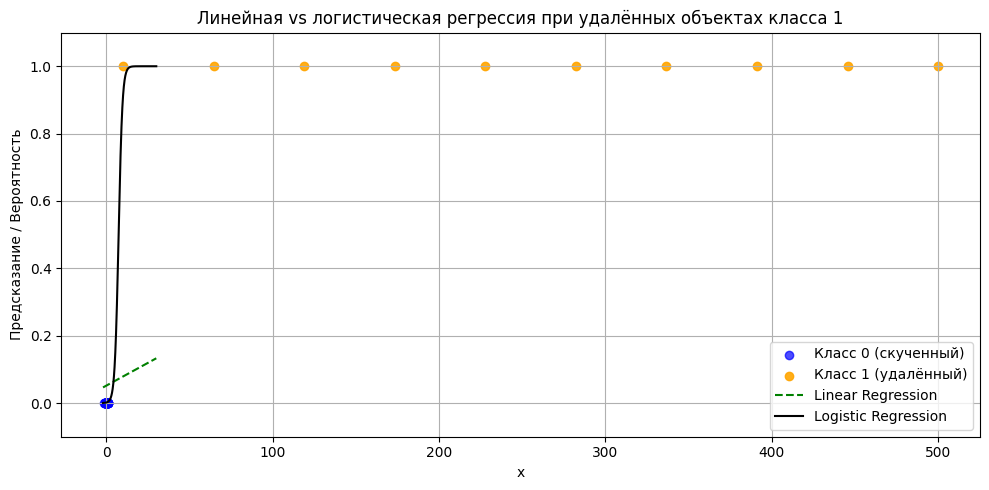

In [111]:
# Новый пример: класс 0 сконцентрирован в одном месте, класс 1 — сильно растянут вправо

# Класс 0 — 50 точек около x = 0
X0 = np.random.normal(loc=0, scale=0.5, size=(50, 1))
y0 = np.zeros(50)

# Класс 1 — 50 точек с растущим x (от 10 до 500)
# X1 = np.linspace(5, 25, 10).reshape(-1, 1)
X1 = np.linspace(10, 500, 10).reshape(-1, 1)
y1 = np.ones(10)

# Объединяем
X_all = np.vstack([X0, X1])
y_all = np.concatenate([y0, y1])

# Обучаем модели
linreg = LinearRegression().fit(X_all, y_all)
logreg = LogisticRegression().fit(X_all, y_all)

# Предсказания на сетке
x_grid = np.linspace(-2, 30, 500).reshape(-1, 1)
lin_preds = linreg.predict(x_grid)
log_probs = logreg.predict_proba(x_grid)[:, 1]

# Визуализация
plt.figure(figsize=(10, 5))
plt.scatter(X0, y0, color='blue', label='Класс 0 (скученный)', alpha=0.7)
plt.scatter(X1, y1, color='orange', label='Класс 1 (удалённый)', alpha=0.9)
plt.plot(x_grid, lin_preds, color='green', linestyle='--', label='Linear Regression')
plt.plot(x_grid, log_probs, color='black', label='Logistic Regression')
plt.xlabel("x")
plt.ylabel("Предсказание / Вероятность")
plt.title("Линейная vs логистическая регрессия при удалённых объектах класса 1")
plt.ylim(-0.1, 1.1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### 9. Многоклассовая классификация. Один-против-одного, один-против-всех, их свойства.

In [104]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
from IPython.display import display

# --- 1. Данные
X, y = load_iris(return_X_y=True)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

# --- 2. Модель
base_model = LogisticRegression(max_iter=1000)

# --- 3. One-vs-Rest (OvR)
clf_ovr = OneVsRestClassifier(base_model).fit(X_tr, y_tr)
y_pred_ovr = clf_ovr.predict(X_te)

# --- 4. One-vs-One (OvO)
clf_ovo = OneVsOneClassifier(base_model).fit(X_tr, y_tr)
y_pred_ovo = clf_ovo.predict(X_te)

# --- 5. Confusion matrices
cm_ovr = confusion_matrix(y_te, y_pred_ovr)
cm_ovo = confusion_matrix(y_te, y_pred_ovo)

print("Confusion Matrix (OvR):")
print(cm_ovr)

print("\nConfusion Matrix (OvO):")
print(cm_ovo)

# --- 6. Разбиения для OvR
ovr_split = pd.DataFrame({
    'Класс': list(range(len(clf_ovr.estimators_))),
    'Положительных': [(y_tr == k).sum() for k in range(len(clf_ovr.estimators_))],
    'Отрицательных': [(y_tr != k).sum() for k in range(len(clf_ovr.estimators_))],
    'Всего': [len(y_tr)] * len(clf_ovr.estimators_)
})

print("\nOvR — разбивка по классам:")
display(ovr_split)

# --- 7. Разбиения для OvO
ovo_pairs = [(est.classes_[0], est.classes_[1]) for est in clf_ovo.estimators_]

ovo_data = []
for a, b in ovo_pairs:
    count_a = np.sum(y_tr == a)
    count_b = np.sum(y_tr == b)
    total = count_a + count_b
    ovo_data.append({
        'Пара классов': f"{a} vs {b}",
        f"#{a}": count_a,
        f"#{b}": count_b,
        'Суммарно': total
    })

ovo_split = pd.DataFrame(ovo_data)

print("\nOvO — разбивка по парам классов:")
display(ovo_split)

# --- 8. Accuracy summary
print(f"\nOvR Accuracy: {accuracy_score(y_te, y_pred_ovr):.3f}")
print(f"OvO Accuracy: {accuracy_score(y_te, y_pred_ovo):.3f}")


Confusion Matrix (OvR):
[[16  0  0]
 [ 0 16  2]
 [ 0  0 11]]

Confusion Matrix (OvO):
[[16  0  0]
 [ 0 17  1]
 [ 0  0 11]]

OvR — разбивка по классам:


,Класс,Положительных,Отрицательных,Всего
0,0,34,71,105
1,1,32,73,105
2,2,39,66,105



OvO — разбивка по парам классов:


,Пара классов,#0,#1,Суммарно
0,0 vs 1,34,32,66
1,0 vs 1,34,32,66
2,0 vs 1,34,32,66



OvR Accuracy: 0.956
OvO Accuracy: 0.978


### 10.Метод опорных векторов. Задача оптимизации для SVM. Трюк с ядром. Свойства ядра.

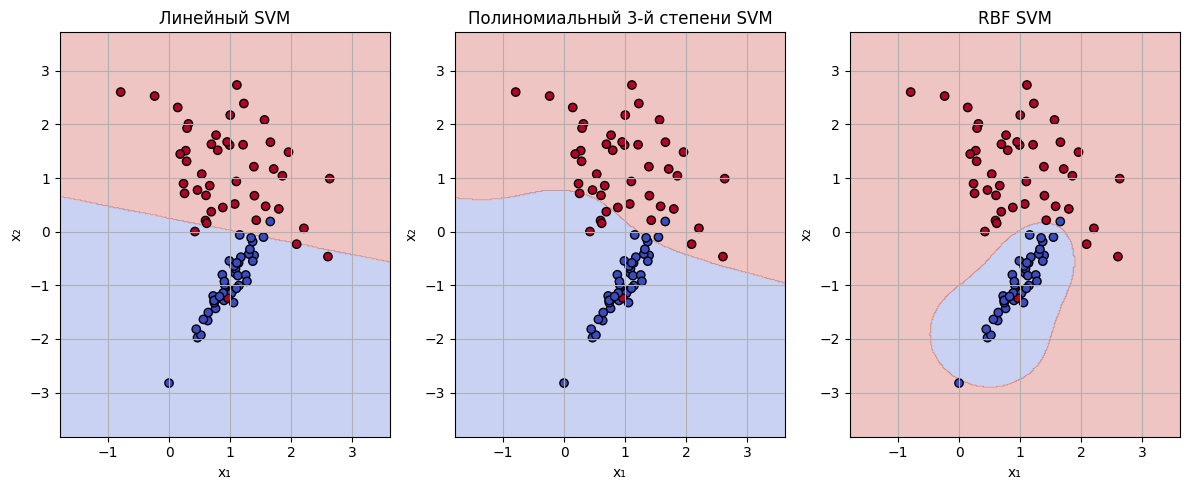

Linear SVM Accuracy: 0.944
Polynomial SVM Accuracy: 0.911
RBF SVM Accuracy: 0.967


In [109]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Данные
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, class_sep=1.0, random_state=42)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

# --- 2. Модели
clf_linear = SVC(kernel='linear', C=1).fit(X_tr, y_tr)
clf_rbf = SVC(kernel='rbf', gamma=1, C=1).fit(X_tr, y_tr)
clf_poly = SVC(kernel='poly', degree=3, C=1).fit(X_tr, y_tr)


# --- 3. Визуализация
def plot_decision_boundary(model, X, y, ax, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    ax.set_title(title)
    ax.set_xlabel("x₁")
    ax.set_ylabel("x₂")
    ax.grid(True)

# --- 4. Графики
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
plot_decision_boundary(clf_linear, X_te, y_te, axes[0], "Линейный SVM")
plot_decision_boundary(clf_poly, X_te, y_te, axes[1], "Полиномиальный 3-й степени SVM")
plot_decision_boundary(clf_rbf, X_te, y_te, axes[2], "RBF SVM")
plt.tight_layout()
plt.show()


y_pred_linear = clf_linear.predict(X_te)
y_pred_poly = clf_poly.predict(X_te)
y_pred_rbf = clf_rbf.predict(X_te)

# Accuracy
acc_linear = accuracy_score(y_te, y_pred_linear)
acc_poly = accuracy_score(y_te, y_pred_poly)
acc_rbf = accuracy_score(y_te, y_pred_rbf)
print(f"Linear SVM Accuracy: {acc_linear:.3f}")
print(f"Polynomial SVM Accuracy: {acc_poly:.3f}")
print(f"RBF SVM Accuracy: {acc_rbf:.3f}")
# Linear SVM Accuracy: 0.944
# Polynomial SVM Accuracy: 0.911
# RBF SVM Accuracy: 0.967